# <h1><center>Q-learning Tutorial</center></h1>

This notebook provides an introductory tutorial to Q-learning. Specifically, we will implement tabular Q-Learning in JAX and use it to steer a simplified brittle star robot toward a target location. The [brittle star robot and its environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star) is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb). Instead of directly outputting joint-level actions, we will use our Q-learning controller to modulate a CPG that outputs the joint-level actions.

The main goal of this tutorial is to give you a practical example that you can play around with to gain intuition in fundamental design choices in reinforcement learning (state representations, action definitions, reward definitions, etc.).

## Q-Learning

Q-learning belongs to the class of [model-free](https://en.wikipedia.org/wiki/Model-free_(reinforcement_learning)) reinforcement algorithms. This means that the algorithm does not require prior knowledge (i.e. a model) of the environment. It also belongs to the class of off-policy algorithms, meaning that it does not use the 'current policy' to produce actions at every timestep.

As its name entails, the algorithm's goal is to learn the function $Q(s, a)$, which represents the expected cumulative reward for taking a particular action $a$ in a given state $s$. In other words, we try to learn a function that predicts the expected payoff of doing a certain action in a given state. Given such a function, we can select the action with the highest expected payoff in every state.

In this tutorial, we will focus on tabular Q-learning. This means that our $Q(s, a)$ function is implemented as a table with discretized states as rows and discretized actions as columns. After a successful optimization, each cell in this table will approximate the Q-value of a state and an action. To get a good action given some state, we can then just select the action that corresponds to the highest Q-value of the row indexed by the discretized state.

Initially, this Q-Table will be populated with zeros or small random values (small random values giving the additional benefit of encouraging some extra initial exploration). The Q-Learning algorithm then tries to optimize the values in this table through an iterative process of exploration and exploitation. During the exploration phase, the agent will take random actions to get information about the environment and update the Q-Table accordingly. As the agent explores more, it gradually transitions into the exploitation phase, where it leverages the learned Q-values to make more informed decisions and maximize the cumulative reward further.

The tabular Q-learning algorithm can be summarized as follows:
1. Initialize the Q-table with arbitrary values or zeros.
2. Observe the current state $s$ of the environment.
3. Choose an action $a$ to take based on an exploration-exploitation trade-off. This can for instance be done by using the epsilon-greedy approach, where the agent selects a random action with probability $\eps$ (exploration) and chooses the action with the highest Q-value with a complementary probability $(1-\eps)$ (exploitation).
4. Perform the chosen action $a$, transition to the next state $s'$ and observe the reward $r$.
5. Update the Q-Table of the state-action pair using the Q-learning update rule<br>
        $Q(s,a) = (1 - \alpha) Q(s,a) + \alpha(r + \gamma\max(Q(s', a')))$,<br>
        where alpha $\alpha$ is the learning rate, gamma $\gamma$ is the discount factor that determines the importance of future rewards, $r$ is the immediate reward obtained (given by the environment), and $\max_{a' \in A}(Q(s', a'))$ represents the maximum Q-value for the next state
6. Repeat steps $2$ to $5$ until convergence or a predefined number of iterations.

A natural extension of the tabular Q-learning algorithm (which is limited to discrete actions and states) is the [Deep Q-Learning (DQN) algorithm](https://huggingface.co/learn/deep-rl-course/unit3/introduction). As its name gives away, the DQN algorithm swaps the Q-table for a deep neural network, which enables mapping continuous states to $Q(s, a)$ values (the network will have one output neuron per action).

## Implementing tabular Q-learning in JAX

When implementing something in JAX it's important to remember that JAX follows the [functional programming paradigm](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions). Put simply, we thus rely on pure functions (deterministic and without side effects) and immutable data structures (instead of changing data in place, new data structures are created with the desired modifications) as primary building blocks.

In [1]:
from typing import Tuple
import functools
import chex
from flax import struct
import jax
import jax.numpy as jnp


@struct.dataclass
class QLearningPolicyParameters:
    q_table: jnp.ndarray
    alpha: float
    epsilon: float
    gamma: float


class QLearningPolicy:
    def __init__(
            self,
            num_states: int,
            num_actions: int
            ) -> None:
        self._num_states = num_states
        self._num_actions = num_actions

    @functools.partial(jax.jit, static_argnums=(0,))
    def apply_q_learning_update_rule(
            self,
            policy_parameters: QLearningPolicyParameters,
            state_index: int,
            next_state_index: int,
            action_index: int,
            reward: float
            ) -> QLearningPolicyParameters:
        old_q_value = policy_parameters.q_table[state_index, action_index]
        best_future_q_value = jnp.max(policy_parameters.q_table[next_state_index])
        q_value_update = reward + policy_parameters.gamma * best_future_q_value
        new_q_value = (1 - policy_parameters.alpha) * old_q_value + policy_parameters.alpha * q_value_update

        new_q_table = policy_parameters.q_table.at[state_index, action_index].set(new_q_value)
        # noinspection PyUnresolvedReferences
        return policy_parameters.replace(q_table=new_q_table)

    @functools.partial(jax.jit, static_argnums=(0,))
    def epsilon_greedy_action(
            self,
            policy_parameters: QLearningPolicyParameters,
            state_index: int,
            rng: chex.PRNGKey
            ) -> Tuple[QLearningPolicyParameters, int]:
        explore_rng, random_action_rng = jax.random.split(rng, 2)
        explore = jax.random.uniform(explore_rng) < policy_parameters.epsilon

        def get_random_action() -> int:
            return jax.random.choice(key=random_action_rng, a=jnp.arange(policy_parameters.q_table.shape[1]))

        def get_greedy_action() -> int:
            return jnp.argmax(policy_parameters.q_table[state_index])

        action_index = jax.lax.cond(
                pred=explore, true_fun=get_random_action, false_fun=get_greedy_action
                )

        return action_index

    @functools.partial(jax.jit, static_argnums=(0,))
    def reset(
            self,
            rng: chex.PRNGKey,
            alpha: float,
            gamma: float,
            epsilon: float
            ) -> QLearningPolicyParameters:
        # noinspection PyArgumentList
        return QLearningPolicyParameters(
                q_table=jax.random.uniform(
                        key=rng,
                        shape=(self._num_states, self._num_actions),
                        dtype=jnp.float32,
                        minval=-0.001,
                        maxval=0.001
                        ), alpha=alpha, epsilon=epsilon, gamma=gamma
                )

## Case study: CPG modulations for directed brittle star locomotion

Now that we have implemented our `QLearningPolicy`, we can apply it to learn how to steer our brittle star toward a target location. To simplify the problem, we will keep the target location fixed. Furthermore, instead of directly outputting joint-level actions, we will use our Q-learning controller to modulate a central pattern generator (CPG) that outputs the joint-level actions.

### Environment setup

Let's start by setting up our brittle star environment. We will use the directed locomotion variant (which we will always supply with the same `jax.random.PRNGKey` in order to keep the target location fixed).
The following cell will first do some preliminary checks to make sure the underlying physics engine (MuJoCo) is correctly loaded and to make sure that JAX can find our GPU.

In [2]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Tue Feb  6 13:26:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      On  | 00000000:3B:00.0 Off |                    0 |
|  0%   49C    P8               8W /  60W |      0MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

This next cell (similar to previous tutorials) defines the `morphology_specification` (i.e. the brittle star morphology), the `arena_configuration` (i.e. some settings w.r.t. the aquarium in which we place the brittle star) and the `environment_configuration` (which defines and configures the directed locomotion task). The cell also implements some utility functions for visualization.

In [3]:
from brb.brittle_star.environment.directed_locomotion.shared import \
    BrittleStarDirectedLocomotionEnvironmentConfiguration
import numpy as np
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from brb.brittle_star.environment.directed_locomotion.dual import BrittleStarDirectedLocomotionEnvironment
from typing import List
import mediapy as media
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena

morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=3, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(1.5, 1.5), sand_ground_color=False, attach_target=True, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarDirectedLocomotionEnvironmentConfiguration(
        target_distance=1.25,
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=10,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )


def create_environment() -> BrittleStarDirectedLocomotionEnvironment:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    env = BrittleStarDirectedLocomotionEnvironment.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend="MJX"
            )
    return env


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None],
        path: str | None = None
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    filtered_images = [image for image in images if image is not None]
    num_nones = len(images) - len(filtered_images)
    if num_nones > 0:
        logging.warning(
                f"env.render produced {num_nones} None's. Resulting video might be a bit choppy (consquence of https://github.com/google-deepmind/mujoco/issues/1379)."
                )
    if path:
        media.write_video(path=path, images=filtered_images)
    return media.show_video(images=filtered_images)

As always, we `jax.jit` the two main environment functions: `step` and `reset`.

In [4]:
rng = jax.random.PRNGKey(seed=0)
env = create_environment()
env_reset_fn = jax.jit(env.reset)
env_step_fn = jax.jit(env.step)

The next cell prints out the environments observation space and action space. As you can see, we explicitly reset the environment with seed $8$, which causes the target to appear in the upper left corner. As stated above, we will always use this seed to reset the environment to keep our target fixed.

Observation space:
Dict('joint_position': Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (30,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (30,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (15,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'unit_xy_direction_to_target': Box(-1.0, 1.0, (2,), <class 'jax.numpy.float32'>), 'xy_distance_to_target': Box(0.0, inf, (1,), <class 'jax.numpy.float32'>))

Action space:
Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>)
Info:
{'time': Array(0., dtype=float32, weak_type=True), 'xy_target_position': Array([-0.73444843,  1.0114769 ], dtype=float32)}


""

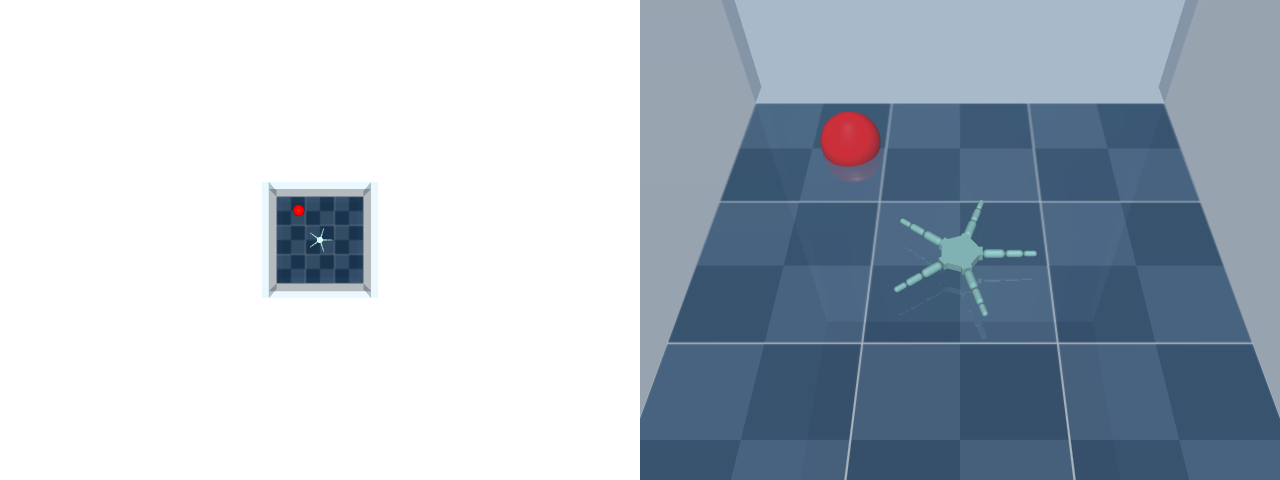

In [5]:
rng, sub_rng = jax.random.split(rng, 2)
env_state = env_reset_fn(rng=jax.random.PRNGKey(seed=8))
print("Observation space:")
print(env.observation_space)
print()
print("Action space:")
print(env.action_space)
print("Info:")
print(env_state.info)
media.show_image(post_render(env.render(env_state), environment_configuration=env.environment_configuration))

### Experimental design

Given our brittle star environment and task definition, we can now design our reinforcement learning experiment. The three main components are the state representation, the actions, and the reward function. When experimenting with reinforcement learning, it is incredibly important to always maintain a very clear overview of these three components (and the environment/morphology configuration). When the learning fails or is slow, it is almost always one of these design choices that lies at the root of it (given that there are no bugs on the environment side).


#### State representation

One of the most important design choices when applying a Q-learning algorithm (and reinforcement learning algorithms in general), is how to represent the state. In other words, what kind of information do we supply to the policy to make it return good actions? Which observations that the environment returns do we use and do we transform them in some way to represent them beter? When deciding on this, a good exercise is to imagine that you are the robot trying to solve the given task; Ask yourself what kind of information you would require. In this case, we also need a discretized state representation, since we're working with tabular Q-Learning.

To keep things as simple as possible, in this tutorial, we will approach this locomotion task from a grid-based perspective. We will discretize the 2D aquarium floor in a 3x3 grid of square cells (one cell of this grid is equal to the 2x2 cells that the rendered aquarium floor above indicates). As a discrete state representation for this directed locomotion task with a fixed target, we will just take the index of the grid cell that the brittle star robot's disk is currently in. As discussed later, our actions will be `move_upwards`, `move_rightwards`, `move_downwards`, and `move_leftwards` (made possible by implementing some modulation tricks with the underlying CPG).

Take a moment to think about this state and action representation. If you were the robot, would this allow you to solve the task? 

Note: during this project, we will always be using simulation environments. Simulation environments are nice since they give us full control over and mainly full observability of everything in the environment (for instance the exact position of the brittle star's disk). In the real world, however, we do not have these characteristics. There we have to purely rely on sensory information (e.g. cameras, touch sensors, motor encoders...) and additional processing to get this kind of information (which is often noisy). Always keep this in mind, and even though we won't do a sim2real transfer during this project, always be able to explain how you would allow your selected state representation to be implemented on a real-world robot. For instance, in this grid-based representation, we could use a downwards-facing camera above the aquarium. Using some computer vision techniques, the brittle star's disk position can be extracted.

This next cell implements our grid-based state representation. We name the function 'state_indexer' as it extracts a row index for our Q-Table.

In [20]:
from mujoco_utils.environment.mjx_env import MJXEnvState

NUM_CELLS_PER_AXIS = 3
ARENA_SIZE = jnp.array(arena_configuration.size)

def discretize_position(position: jnp.ndarray) -> jnp.ndarray:
    shifted_position = position + ARENA_SIZE 
    normalized_position = shifted_position / (2 * ARENA_SIZE)
    
    return (NUM_CELLS_PER_AXIS * normalized_position).astype(jnp.int32)

@jax.jit
def state_indexer(
        env_state: MJXEnvState
        ) -> int:
    robot_position = env_state.observations["disk_position"][:2]
    robot_x, robot_y = discretize_position(position=robot_position)
    state_index = robot_x + NUM_CELLS_PER_AXIS * robot_y
    
    return state_index

#### Actions

Maintaining our grid-based perspective, we will define actions that allow traversing this grid: `move_up`, `move_right`, `move_down`, and `move_left`. But how do we need to control the robot's motors to make it move in a certain direction? Luckily, we already know how to use and modulate central pattern generators to mimic rowing behavior in brittle stars. The CPG tutorial showed us how to define an appropriate CPG model to do so and even implemented a function that provides the modulations needed to assign a leading arm (causing the brittle star to move in the direction of that arm).

To implement our grid-based actions, we can thus rely on this previously implemented functionality and just select the arm that is pointing toward the requested direction the most as the leading arm.
The next cell first copies the CPG implementation, the CPG creation, and the leading-arm-based modulation from the CPG tutorial.

In [37]:
import functools
from flax import struct
import jax
import jax.numpy as jnp
import chex
from functools import partial
from typing import Tuple

from typing import Callable


def euler_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, y)
    next_y = y + delta_time * slope
    return next_y


@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    dot_amplitudes: jnp.ndarray  # first order derivative of the amplitude
    amplitudes: jnp.ndarray
    dot_offsets: jnp.ndarray  # first order derivative of the offset 
    offsets: jnp.ndarray
    outputs: jnp.ndarray

    # We'll make these modulatory parameters part of the state as they will change as well
    R: jnp.ndarray
    X: jnp.ndarray
    omegas: jnp.ndarray
    rhos: jnp.ndarray


class CPG:
    def __init__(
            self,
            weights: jnp.ndarray,
            amplitude_gain: float = 20,
            offset_gain: float = 20,
            dt: float = 0.01,
            ) -> None:
        self._weights = weights
        self._amplitude_gain = amplitude_gain
        self._offset_gain = offset_gain
        self._dt = dt
        self._solver = euler_solver

    @property
    def num_oscillators(
            self
            ) -> int:
        return self._weights.shape[0]

    @staticmethod
    def phase_de(
            weights: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray,
            phase_biases: jnp.ndarray,
            omegas: jnp.ndarray
            ) -> jnp.ndarray:
        @jax.vmap  # vectorizes this function for us over an additional batch dimension (in this case over all oscillators)
        def sine_term(
                phase_i: float,
                phase_biases_i: float
                ) -> jnp.ndarray:
            return jnp.sin(phases - phase_i - phase_biases_i)

        couplings = jnp.sum(weights * amplitudes * sine_term(phase_i=phases, phase_biases_i=phase_biases), axis=1)
        return omegas + couplings

    @staticmethod
    def second_order_de(
            gain: jnp.ndarray,
            modulator: jnp.ndarray,
            values: jnp.ndarray,
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:

        return gain * ((gain / 4) * (modulator - values) - dot_values)

    @staticmethod
    def first_order_de(
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return dot_values

    @staticmethod
    def output(
            offsets: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray
            ) -> jnp.ndarray:
        return offsets + amplitudes * jnp.cos(phases)

    def reset(
            self,
            rng: chex.PRNGKey
            ) -> CPGState:
        phase_rng, amplitude_rng, offsets_rng = jax.random.split(rng, 3)
        # noinspection PyArgumentList
        state = CPGState(
                phases=jax.random.uniform(
                        key=phase_rng, shape=(self.num_oscillators,), dtype=jnp.float32, minval=-0.01, maxval=0.01
                        ),
                amplitudes=jnp.zeros(self.num_oscillators),
                offsets=jnp.zeros(self.num_oscillators),
                dot_amplitudes=jnp.zeros(self.num_oscillators),
                dot_offsets=jnp.zeros(self.num_oscillators),
                outputs=jnp.zeros(self.num_oscillators),
                time=0.0,
                R=jnp.zeros(self.num_oscillators),
                X=jnp.zeros(self.num_oscillators),
                omegas=jnp.zeros(self.num_oscillators),
                rhos=jnp.zeros_like(self._weights)
                )
        return state

    @functools.partial(jax.jit, static_argnums=(0,))
    def step(
            self,
            state: CPGState
            ) -> CPGState:
        # Update phase
        new_phases = self._solver(
                current_time=state.time,
                y=state.phases,
                derivative_fn=lambda
                    t,
                    y: self.phase_de(
                        omegas=state.omegas,
                        amplitudes=state.amplitudes,
                        phases=y,
                        phase_biases=state.rhos,
                        weights=self._weights
                        ),
                delta_time=self._dt
                )
        new_dot_amplitudes = self._solver(
                current_time=state.time,
                y=state.dot_amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._amplitude_gain, modulator=state.R, values=state.amplitudes, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_amplitudes = self._solver(
                current_time=state.time,
                y=state.amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_amplitudes),
                delta_time=self._dt
                )
        new_dot_offsets = self._solver(
                current_time=state.time,
                y=state.dot_offsets,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._offset_gain, modulator=state.X, values=state.offsets, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_offsets = self._solver(
                current_time=0,
                y=state.offsets,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_offsets),
                delta_time=self._dt
                )

        new_outputs = self.output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
        # noinspection PyUnresolvedReferences
        return state.replace(
                phases=new_phases,
                dot_amplitudes=new_dot_amplitudes,
                amplitudes=new_amplitudes,
                dot_offsets=new_dot_offsets,
                offsets=new_offsets,
                outputs=new_outputs,
                time=state.time + self._dt
                )


def create_cpg() -> CPG:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    adjacency_matrix = jnp.zeros((10, 10))
    # Connect oscillators within an arm
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)
    # Connect IP oscillators of neighbouring arms
    adjacency_matrix = adjacency_matrix.at[
        ip_oscillator_indices, jnp.concatenate((ip_oscillator_indices[1:], jnp.array([ip_oscillator_indices[0]])))].set(
            1
            )
    # Connect OOP oscillators of neighbouring arms
    adjacency_matrix = adjacency_matrix.at[oop_oscillator_indices, jnp.concatenate(
            (oop_oscillator_indices[1:], jnp.array([oop_oscillator_indices[0]]))
            )].set(1)

    # Make adjacency matrix symmetric (i.e. make all connections bi-directional)
    adjacency_matrix = jnp.maximum(adjacency_matrix, adjacency_matrix.T)

    return CPG(
            weights=5 * adjacency_matrix,
            amplitude_gain=20,
            offset_gain=20,
            dt=environment_configuration.control_timestep
            )


def get_oscillator_indices_for_arm(
        arm_index: int
        ) -> Tuple[int, int]:
    return arm_index * 2, arm_index * 2 + 1


@jax.jit
def modulate_cpg(
        cpg_state: CPGState,
        leading_arm_index: int,
        joint_limit: float
        ) -> CPGState:
    left_rower_arm_indices = [(leading_arm_index - 1) % 5, (leading_arm_index - 2) % 5]
    right_rower_arm_indices = [(leading_arm_index + 1) % 5, (leading_arm_index + 2) % 5]

    leading_arm_ip_oscillator_index, leading_arm_oop_oscillator_index = get_oscillator_indices_for_arm(
            arm_index=leading_arm_index
            )

    R = jnp.zeros_like(cpg_state.R)
    X = jnp.zeros_like(cpg_state.X)
    rhos = jnp.zeros_like(cpg_state.rhos)
    omegas = 3 * jnp.pi * jnp.ones_like(cpg_state.omegas)
    phases_bias_pairs = []

    def modulate_leading_arm(
            _X: jnp.ndarray,
            _arm_index: int
            ) -> jnp.ndarray:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        return _X.at[oop_oscillator_index].set(joint_limit)

    def modulate_left_rower(
            _R: jnp.ndarray,
            _arm_index: int
            ) -> Tuple[jnp.ndarray, List[Tuple[int, int, float]]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _R = _R.at[ip_oscillator_index].set(joint_limit)
        _R = _R.at[oop_oscillator_index].set(joint_limit)
        _phase_bias_pairs = [(ip_oscillator_index, oop_oscillator_index, jnp.pi / 2)]
        return _R, _phase_bias_pairs

    def phase_biases_first_left_rower(
            _arm_index: int
            ) -> List[Tuple[int, int, float]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _phase_bias_pairs = [(ip_oscillator_index, leading_arm_ip_oscillator_index, jnp.pi / 4),
                             (leading_arm_oop_oscillator_index, oop_oscillator_index, jnp.pi / 4)]
        return _phase_bias_pairs

    def modulate_right_rower(
            _R: jnp.ndarray,
            _arm_index: int
            ) -> Tuple[jnp.ndarray, List[Tuple[int, int, float]]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _R = _R.at[ip_oscillator_index].set(joint_limit)
        _R = _R.at[oop_oscillator_index].set(joint_limit)
        _phase_bias_pairs = [(oop_oscillator_index, ip_oscillator_index, jnp.pi / 2)]
        return _R, _phase_bias_pairs

    def phase_biases_first_right_rower(
            _arm_index: int
            ) -> List[Tuple[int, int, float]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _phase_bias_pairs = [(leading_arm_ip_oscillator_index, ip_oscillator_index, jnp.pi / 4),
                             (oop_oscillator_index, leading_arm_oop_oscillator_index, jnp.pi / 4)]
        return _phase_bias_pairs

    def phase_biases_second_rowers(
            _left_arm_index: int,
            _right_arm_index: int
            ) -> List[Tuple[int, int, float]]:
        left_ip_oscillator_index, _ = get_oscillator_indices_for_arm(arm_index=_left_arm_index)
        right_ip_oscillator_index, _ = get_oscillator_indices_for_arm(arm_index=_right_arm_index)
        _phase_bias_pairs = [(left_ip_oscillator_index, right_ip_oscillator_index, jnp.pi)]
        return _phase_bias_pairs

    X = modulate_leading_arm(_X=X, _arm_index=leading_arm_index)

    R, phb = modulate_left_rower(_R=R, _arm_index=left_rower_arm_indices[0])
    phases_bias_pairs += phb

    R, phb = modulate_left_rower(_R=R, _arm_index=left_rower_arm_indices[1])
    phases_bias_pairs += phb

    R, phb = modulate_right_rower(_R=R, _arm_index=right_rower_arm_indices[0])
    phases_bias_pairs += phb

    R, phb = modulate_right_rower(_R=R, _arm_index=right_rower_arm_indices[1])
    phases_bias_pairs += phb

    phases_bias_pairs += phase_biases_first_left_rower(_arm_index=left_rower_arm_indices[0])
    phases_bias_pairs += phase_biases_first_right_rower(_arm_index=right_rower_arm_indices[0])

    phases_bias_pairs += phase_biases_second_rowers(
            _left_arm_index=left_rower_arm_indices[1], _right_arm_index=right_rower_arm_indices[1]
            )

    for oscillator1, oscillator2, bias in phases_bias_pairs:
        rhos = rhos.at[oscillator1, oscillator2].set(bias)
        rhos = rhos.at[oscillator2, oscillator1].set(-bias)

    # noinspection PyUnresolvedReferences
    return cpg_state.replace(
            R=R, X=X, rhos=rhos, omegas=omegas
            )


@jax.jit
def map_cpg_outputs_to_actions(
        cpg_state: CPGState
        ) -> jnp.ndarray:
    num_arms = morphology_specification.number_of_arms
    num_oscillators_per_arm = 2
    num_segments_per_arm = morphology_specification.number_of_segments_per_arm[0]

    cpg_outputs_per_arm = cpg_state.outputs.reshape((num_arms, num_oscillators_per_arm))
    cpg_outputs_per_segment = cpg_outputs_per_arm.repeat(num_segments_per_arm, axis=0)

    actions = cpg_outputs_per_segment.flatten()
    return actions

Given the CPG implementation above, we can now implement our 'action mapper', i.e. the function that maps a discrete action index (column in our Q-Table) to the actuator-level control commands our environment expects. To recap, for every environment step, the following will happen:

<br>`environment observations` $\rightarrow$ `state index (denoting the grid cell)` $\rightarrow$ `Epsilon-greedy policy` $\rightarrow$ `action index (a movement direction)` $\rightarrow$ `leading arm` $\rightarrow$ `CPG modulation` $\rightarrow$ `CPG outputs` $\rightarrow$ `actuator controls`<be>


In this case, the `action_index` is defined as:
- 0 -> move up
- 1 -> move right
- 2 -> move down
- 3 -> move left

In [38]:
from typing import Dict

MOVE_DIRECTIONS = jnp.array([
        [0, 1],
        [1, 0],
        [0, -1],
        [-1, 0]
        ])

# This corresponds to the angles at which arms are attached to the central disk
ARM_ANGLES = jnp.linspace(0, 2 * jnp.pi, morphology_specification.number_of_arms + 1)[:-1]

@partial(jax.vmap, in_axes=(None, 0))
def angle_between_vectors(a: jnp.ndarray, b: jnp.ndarray) -> float:
    return jnp.arccos(jnp.clip(jnp.dot(a, b) / (jnp.linalg.norm(a) * jnp.linalg.norm(b)), -1.0, 1.0))

@functools.partial(jax.jit, static_argnums=(0,))
def cpg_action_mapper(
        cpg: CPG,
        cpg_state: CPGState,
        action_index: int,
        env_state: MJXEnvState,
        joint_limit: float
        ) -> Tuple[CPGState, jnp.ndarray]:
    disk_rotation_wrt_x_axis = env_state.observations["disk_rotation"][-1] 
    rotation_per_arm = ARM_ANGLES + disk_rotation_wrt_x_axis
    direction_per_arm = jnp.stack((jnp.cos(rotation_per_arm), jnp.sin(rotation_per_arm))).T
    
    target_direction = MOVE_DIRECTIONS[action_index]
    
    # Get closest arm to movement direction -> calculate angles via dot product and then use arm that has the minimum angle error
    deviation_per_arm = angle_between_vectors(target_direction, direction_per_arm)
    leading_arm = jnp.argmin(deviation_per_arm)
    
    cpg_state = modulate_cpg(cpg_state=cpg_state, leading_arm_index=leading_arm, joint_limit=joint_limit)
    cpg_state = cpg.step(state=cpg_state)
    actions = map_cpg_outputs_to_actions(cpg_state=cpg_state)
    return cpg_state, actions

##### Visual validation

Before we continue, let's first check the correctness of our current code (mainly the action mapper) by visualizing some episodes.

In [39]:
def visualize_episode(policy_parameters: QLearningPolicyParameters, rng: chex.PRNGKey) -> None:
    cpg_rng, policy_rng = jax.random.split(rng, 2) 
    
    env_state = env_reset_fn(rng=jax.random.PRNGKey(seed=8))
    cpg_state = cpg.reset(cpg_rng)
    
    # noinspection PyUnresolvedReferences
    # make the policy deterministic
    policy_parameters = policy_parameters.replace(epsilon=0)
    
    frames = []
    while not(env_state.terminated | env_state.truncated):
        state_index = state_indexer(env_state)
        action_index = q_learning_policy.epsilon_greedy_action(
                policy_parameters=policy_parameters, state_index=state_index, rng=policy_rng
                ) 
        cpg_state, actions = cpg_action_mapper(cpg=cpg, cpg_state=cpg_state, env_state=env_state, action_index=action_index, joint_limit=env.action_space.high[0] * 0.5)
        
        env_state = env_step_fn(env_state, actions)
        frame = post_render(env.render(state=env_state), environment_configuration=environment_configuration)
        frames.append(frame)
    
    show_video(images=frames)

We have four actions. For each action, we will run one episode in which we always use that action. This can be done by overwriting the underlying Q-Table and setting a high value for that action's column. If we then set the epsilon parameter to zero, the `QLearningPolicy` will always select the desired action.

In [40]:
q_learning_policy = QLearningPolicy(num_states=9, num_actions=4)
cpg = create_cpg()

rng, episode_rng, q_learner_rng = jax.random.split(rng, 3)
policy_parameters = q_learning_policy.reset(rng=q_learner_rng, alpha=0.01, gamma=0.90, epsilon=0.0)

for action_index, label in enumerate(["move up", "move right", "move down", "move left"]):
    adapted_policy_parameters = policy_parameters.replace(q_table=policy_parameters.q_table.at[:, action_index].set(10))
    print(f"Action: {label}")
    visualize_episode(policy_parameters=adapted_policy_parameters, rng=episode_rng)

Action: move up


Action: move right


Action: move down


Action: move left


Looking good! As you can notice, however, the brittle star does not perfectly follow the requested direction. The main reason for this is that we cannot expect the brittle star to always have a leading arm pointing perfectly toward the requested direction. This makes our state transition thus even more stochastic (e.g. going up doesn't always mean that we will move one cell up). Nevertheless, if we collect enough data, our Q-Learning algorithm should be able to handle this additional complexity.

#### Reward
The last important design choice when applying RL is the reward function. The reward is our main way to tell our policy what we want it to learn.
The `BrittleStarDirectedLocomotionEnvironment` defines the reward as the difference between the previous distance to the target and the current distance to the target (as shown [here](https://github.com/Co-Evolve/brb/blob/new-framework/brb/brittle_star/environment/directed_locomotion/shared.py#L28)). While this is a solid default choice, here we will use a slightly different reward $r$:

$r = 
\begin{cases} 
-0.001 & \text{if target reached} \\
1000 & \text{otherwise}
\end{cases}$

This reward provides less 'information' than the original reward; it is a ['sparse' reward](https://www.geeksforgeeks.org/sparse-rewards-in-reinforcement-learning/). We will use this reward because it gives a nice example of how important exploration is; If the agent does not explore well enough, it will never reach the target and thus never receive the positive reward. Consequently, it will never learn. The negative constant reward that is given at every timestep can be seen as a time penalty; I.e. the longer it takes for the agent to reach the goal, the smaller the total reward. This will thus stimulate our policy to reach the target as fast as possible.

Note: keep in mind that you're never limited to the reward function that the environment provides by default!

In [41]:
from mujoco_utils.environment.mjx_env import MJXEnvState

def calculate_reward(state: MJXEnvState) -> float:
    pred = state.terminated    # If this is True, we have reached the target

    def distance_delta_reward() -> float:
        return -0.001

    def target_reached_reward() -> float:
        return 1000.0

    return jax.lax.cond(pred, target_reached_reward, distance_delta_reward)

### Rollout function
Now that we have implemented our experimental setup, we can now implement our 'rollout' or 'playout' function.
This function runs an entire simulation episode, using the policy defined by given parameters. Normally, a rollout function just returns the collected data (i.e. $(s, a, s', r)$ samples. In this case, however, we want our policy to be updated after every step (since we are using temporal difference learning). Consequently, here we will also return the updated policy parameters.

Note: The rollout function implementation in the next cell does not take early environment terminations into account (these occur when the robot has reached the target location before the allocated time). The reason for this is that we use the [jax.lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) function, which always runs a given function for a fixed number of times. While we could also use a [jax.lax.while_loop](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.while_loop.html) to allow early stopping, the general rule-of-thumb when using JAX effectively is to run loops for a fixed number of times. So instead, the implementation below just stops updating the policy parameters once the episode is terminated.

In [26]:
@jax.jit
def rollout_with_policy_updates(
        rng: chex.PRNGKey,
        policy_parameters: QLearningPolicyParameters
        ) -> Dict[str, jnp.ndarray]:
    """
    Do a single episode rollout
    """
    cpg_rng, policy_rng = jax.random.split(rng, 2)
    env_state = env_reset_fn(rng=jax.random.PRNGKey(seed=8))
    cpg_state = cpg.reset(rng=cpg_rng)
    
    def policy_step(
            _state: Tuple[MJXEnvState, QLearningPolicyParameters, CPGState, chex.PRNGKey],
            _: None
            ) -> Tuple[Tuple[MJXEnvState, QLearningPolicyParameters, CPGState], Dict[str, Union[int, float]]]:
        _env_state, _policy_parameters, _cpg_state, _policy_rng = _state
        _state_index = state_indexer(_env_state)

        _policy_rng, _sub_rng = jax.random.split(_policy_rng, 2)
        _action_index = q_learning_policy.epsilon_greedy_action(
                policy_parameters=_policy_parameters, state_index=_state_index, rng=_sub_rng
                )
        _next_cpg_state, _actions = cpg_action_mapper(
                cpg=cpg, cpg_state=_cpg_state, action_index=_action_index, env_state=_env_state, joint_limit=env.action_space.high[0] * 0.5
                )
        _next_env_state = env_step_fn(state=_env_state, action=_actions)

        _next_state_index = state_indexer(_next_env_state)
        carry = (_next_env_state, _next_policy_parameters, _next_cpg_state, _policy_rng)
        return carry, {
                "state_index": _state_index, "next_state_index": _next_state_index, "action_index": _action_index,
                "reward": calculate_reward(_next_env_state), "done": _next_env_state.terminated | _next_env_state.truncated}

    _, scan_out = jax.lax.scan(
            policy_step,
            (env_state, rng_policy_parameters, cpg_state),
            (),
            env.environment_configuration.total_num_control_steps
            )
    
    return scan_out

### Logging via WandB
We will be using [Weights And Biases (W&B)](https://docs.wandb.ai/quickstart) for logging. W&B is an easy-to-use experiment tracker, and allows us to log to an online dashboard (hosted on the cloud) directly from our python code. Before continuing, checkout the following [quickstart](https://docs.wandb.ai/quickstart). Be sure to create and account!

In [16]:
import sys
!{sys.executable} -m pip install -q wandb
import wandb

### Train function

* Rollout data will contain samples that are obtained after the goal was terminated: we will stop updating once this was done.

In [57]:
from typing import Union


def update_policy(
        policy_parameters: QLearningPolicyParameters,
        rollout_data: Dict[str, jnp.ndarray]
        ) -> QLearningPolicyParameters:
    
    def _update_step(
            carry: Tuple[QLearningPolicyParameters, bool],
            data_sample: Dict[str, Union[int, float]]
            ):
        _policy_parameters, _previous_was_last = carry
        
        def _fake_update():
            return _policy_parameters
            
        def _do_update():
            _updated_policy_parameters = q_learning_policy.apply_q_learning_update_rule(
                    policy_parameters=_policy_parameters,
                    state_index=data_sample["state_index"],
                    next_state_index=data_sample["next_state_index"],
                    action_index=data_sample["action_index"],
                    reward=data_sample["reward"]
                    )
            return _updated_policy_parameters

        _policy_parameters = jax.lax.cond(_previous_was_last, _fake_update, _do_update)
        _previous_was_last |= data_sample["done"]
        return (_policy_parameters, _previous_was_last), None

    (policy_parameters, _), _ = jax.lax.scan(
        _update_step, (policy_parameters, False), rollout_data
        )
    return policy_parameters

In [52]:
from tqdm import tqdm

wandb.init(project="SEL3-2024-QL-Tutorial")

NUM_EPISODES = 100

rng = jax.random.PRNGKey(seed=0)
rng, q_learner_rng = jax.random.split(rng, 2)
q_learning_policy = QLearningPolicy(num_states=9, num_actions=4)
policy_parameters = q_learning_policy.reset(rng=q_learner_rng, alpha=0.01, gamma=0.95, epsilon=0.3)
cpg = create_cpg()

for episode_i in tqdm(range(NUM_EPISODES), desc="Training policy"):
    rng, sub_rng = jax.random.split(rng, 2)
    rollout_data = rollout(rng=sub_rng, policy_parameters=policy_parameters)
    policy_parameters = update_policy(policy_parameters=policy_parameters, rollout_data=rollout_data)
    wandb.log({"Task/cumulative-reward": jnp.sum(rollout_data["reward"][:jnp.argmax(rollout_data["done"])]), "Task/succes": int(jnp.argmax(rollout_data["done"]) < environment_configuration.total_num_control_steps - 1), "Q-Table/average-value": jnp.average(policy_parameters.q_table), "Hyperparameters/epsilon": policy_parameters.epsilon, "General/total-num-episodes": episode_i})

wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


General/total-num-episodes,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Hyperparameters/epsilon,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Q-Table/average-value,▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
Task/cumulative-reward,▃▅▆▇▆█▅▄▆▃▃▁▄▇▇▇▇▃▄▃▆▆▆▇█▆▅
Task/succes,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
General/total-num-episodes,26
Hyperparameters/epsilon,0.3
Q-Table/average-value,0.00434
Task/cumulative-reward,0.44842
Task/succes,0


Training policy: 100%|██████████| 100/100 [03:23<00:00,  2.04s/it]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


General/total-num-episodes,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Hyperparameters/epsilon,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Q-Table/average-value,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇██
Task/cumulative-reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▅█▆▇▇▇▆▃▁▇▇▆▆▆▆▆▆▁▆▇▇▇▇
Task/succes,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁████████▁████████▁█████
General/total-num-episodes,99
Hyperparameters/epsilon,0.3
Q-Table/average-value,25.80178
Task/cumulative-reward,-0.163
Task/succes,1


In [53]:
test_parameters = policy_parameters.replace(epsilon=0.0)
rng, episode_rng = jax.random.split(rng, 2)
visualize_episode(policy_parameters=test_parameters, rng=episode_rng)

### Exploit JAX: vectorize!

* Two approaches: train multiple agents (e.g. when testing different hyperparameters) OR train a single agent with parallel data collection
    * Single agent -> width vs depth trade-off
    * Width -> possibly slower training, but more stable (smaller updates due to average), more exploration as well
* Todo: compare training times

#### Single agent with parallel rollouts

In [66]:
vectorized_rollout = jax.jit(jax.vmap(rollout, in_axes=(0, None),))
vectorized_update = jax.jit(jax.vmap(update_policy, in_axes=(None, 0),))

In [68]:
wandb.init(project="SEL3-2024-QL-Tutorial")

NUM_EPISODES = 50
NUM_PARALLEL_ENVS = 32

rng = jax.random.PRNGKey(seed=0)
rng, q_learner_rng = jax.random.split(rng, 2)
policy_parameters = q_learning_policy.reset(rng=q_learner_rng, alpha=0.01, gamma=0.95, epsilon=0.3)
cpg = create_cpg()

for iteration in tqdm(range(NUM_EPISODES), desc="Training policy"):
    rng, *sub_rngs = jax.random.split(rng, NUM_PARALLEL_ENVS + 1)
    rollout_data = vectorized_rollout(jnp.array(sub_rngs), policy_parameters)
    average_total_reward = jnp.average(jnp.sum(rollout_data["reward"], axis=0))

    batch_policy_parameters = vectorized_update(policy_parameters, rollout_data)
    policy_parameters = batch_policy_parameters.replace(
        q_table=jnp.average(batch_policy_parameters.q_table, axis=0),
        epsilon=batch_policy_parameters.epsilon[0],
        alpha=batch_policy_parameters.alpha[0],
        rng=batch_policy_parameters.rng[0],
        gamma=batch_policy_parameters.gamma[0],
    )
    
    wandb.log({"Task/cumulative-reward": jnp.average(jnp.cumsum(rollout_data["reward"], axis=1)[jnp.arange(NUM_PARALLEL_ENVS), jnp.argmax(rollout_data["done"], axis=1)]), "Task/succes-rate": jnp.average(jnp.argmax(rollout_data["done"], axis=1) < environment_configuration.total_num_control_steps - 1), "Q-Table/average-value": jnp.average(policy_parameters.q_table), "Hyperparameters/epsilon": policy_parameters.epsilon, "General/total-num-episodes": iteration * NUM_PARALLEL_ENVS})

wandb.finish()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training policy: 100%|██████████| 100/100 [08:14<00:00,  4.94s/it]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


General/total-num-episodes,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Hyperparameters/epsilon,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Q-Table/average-value,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇█████
Task/cumulative-reward,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▆▁▁▄▆▂▆▁▂▆▃▃▆▂█▂▇▂▇▆▂▁▁▅▁▇
Task/succes-rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▆▆▆▆▇▆▆▇▅▆▅▄▆▇▇▇▇▅▇▆█▇▅▆▆▇
General/total-num-episodes,3168
Hyperparameters/epsilon,0.3
Q-Table/average-value,10.85508
Task/cumulative-reward,41156.04297
Task/succes-rate,0.59375


In [69]:
test_parameters = policy_parameters.replace(epsilon=0.0)
visualize_episode(policy_parameters=test_parameters, rng=jax.random.PRNGKey(8))

### Conclusion

* todo: Recap what we did
* Todo: Focus on importance of exploration -> as soon as we hit the big reward once -> exploit path in QTAble
* todo: describe improvements to the training
* todo: describe problems with the controller (i.e. why do we need a more complex one)
* todo: describe the problems with this controller (although it is adaptive to the target location, its non-adaptive w.r.t. touch) (the modulation parameters are manually defined, but not optimal / realstic) (this is a centralized controller, we want a decentralized one (e.g. to handle loss of arms))
* todo: say that the later goal is to modulate the cpg on a lower level, i.e. the actual amplitudes, offsets, frequencies and phase biases (these will be our actions). Possibly we can remove the connections between oscillators and trust the high level controller to synchronize them / or we can use a single parameter for multiple phase biases
* Main goal of this tutorial: get intuition with respect to state/action representations and RL

* Always have a clear schematic showing your state representation, actions and reward -> debugging

## Next steps

In general: try to improve the learning as well as possible so that you can complexify the task

* Try to improve the training
    * Add an evaluation every n rollouts with epsilon set to 0 -> allows better tracking of the learning (you can even visualize this and send it to wandb)
    * Reduce the epsilon over time
    * Reduce learning rate over time
    * Try do define a better reward (i.e. that gives more information)
    * Tune hyperparameters (e.g. by parallelizing over different options)
    * Normally we do the update every step, but here we do it after an entire episode. Is there a better way to iterate over the collected data?
    * Better exploration:
        * An issue with random exploration is that this often causes oscillatory behaviour (i.e. the robot not truly getting anywhere because actual movement requires coordinated motion). In this case, this could be because the leading arm switches every timestep. Try to find a way to improve exploration initially (during a kind of data collection phase).
* Introduce variability in targhet location
    * You will need to make sure that env.reset receives different seeds
    * You will need to adapt the state representation -> needs to incorporate target location
    * Here you could define a curriculum
        * Start with an environment that has its targets closer, then gradually increase distance to target
* Play around with different state and action representations
    * Often a better idea to make the state direction dependent instead of position dependent (less different states)
* Modify the control loop such that we only modulate the CPG every X control steps (i.e. lower modulation frequency)
* Make the controller decentralized
    * You'll need to make the states and actions arm specific
    * You'll need to update the modulate_cpg function
    * E.g. like this:
        * Actions -> defines the role of the arm -> [leading arm, left rower, right rower]
        * State = [arm is closest to target, arm is on left axis, arm is on right axis]
        * You'll have to modify the CPG as well!